In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [3]:
file_path = '../Data/Processed/rating_numeric.csv'

In [4]:
data = pd.read_csv(file_path, header=0, index_col=[0, 1])

# Convert start_time and end_time to datetime format
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])

# Drop the 'appraisal' column as it is non-numeric
data = data.drop(columns=['appraisal'])

In [5]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3160 entries, ('5588b2bffdf99b7a7714efd1', 22) to ('6613a814a0c2d6cb21da8ef8', 478)
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_time          3160 non-null   datetime64[ns]
 1   end_time            3160 non-null   datetime64[ns]
 2   wander_speed        3160 non-null   float64       
 3   wander_roundness    3160 non-null   float64       
 4   wander_cycle_rate   3160 non-null   float64       
 5   blink_temperature   3160 non-null   float64       
 6   blink_slope         3160 non-null   float64       
 7   blink_cycle_rate    3160 non-null   float64       
 8   beep_pitch          3160 non-null   float64       
 9   beep_slope          3160 non-null   float64       
 10  beep_cycle_rate     3160 non-null   float64       
 11  joy_intensity       3160 non-null   float64       
 12  sadness_intensity   3160 non-null   float64 

In [6]:
data.describe(include=np.number)

,wander_speed,wander_roundness,wander_cycle_rate,blink_temperature,blink_slope,blink_cycle_rate,beep_pitch,beep_slope,beep_cycle_rate,joy_intensity,sadness_intensity,fear_intensity,anger_intensity,disgust_intensity,surprise_intensity,pleasure,arousal,dominance
count,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000
mean,64.921428,0.499199,3.243139,0.499988,0.000949,3.246414,549.134563,0.001582,3.251742,1.720570,1.555696,1.461709,1.125949,0.875949,1.480380,4.341772,5.107595,4.447468
std,20.211122,0.289483,1.587420,0.289394,0.708336,1.586113,260.310957,0.708782,1.583781,1.584615,1.515374,1.502069,1.335216,1.172030,1.406671,2.343343,2.112492,2.145638
min,30.059533,0.000103,0.502657,0.000461,-1.000000,0.506117,100.388060,-1.000000,0.506093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,47.437881,0.246311,1.868632,0.248100,-1.000000,1.874930,323.997898,-1.000000,1.878336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,3.000000
50%,64.747286,0.497217,3.229217,0.501358,0.000000,3.248918,548.284312,0.000000,3.251068,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000,5.000000,5.000000
75%,82.412757,0.749371,4.614483,0.750929,1.000000,4.617121,773.537894,1.000000,4.616167,3.000000,3.000000,3.000000,2.000000,1.000000,3.000000,6.000000,7.000000,6.000000
max,99.990994,0.998869,5.994862,0.998560,1.000000,5.993133,999.495559,1.000000,5.999463,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


In [7]:
data.head()

start_time            end_time  \
participant_id           video_id                                           
5588b2bffdf99b7a7714efd1 22       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         43       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         50       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         84       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         125      2024-05-08 22:59:00 2024-05-08 23:40:00   

                                   wander_speed  wander_roundness  \
participant_id           video_id                                   
5588b2bffdf99b7a7714efd1 22           62.775115          0.688911   
                         43           61.110970          0.352980   
                         50           46.017272          0.530403   
                         84           78.659842          0.963506   
                         125          74.946312          0.498299   

                                   wander_cycle_rate  blink_temperature  \
participant_id           video_id                                         
5588b2bffdf99b7a7714efd1 22                 3.862264           0.504496   
                         43                 4.637822           0.929641   
                         50                 3.425497           0.943638   
                         84                 4.025686           0.931626   
                         125                3.467634           0.330719   

                                   blink_slope  blink_cycle_rate  beep_pitch  \
participant_id           video_id                                              
5588b2bffdf99b7a7714efd1 22                0.0          4.403772  123.816519   
                         43                0.0          3.738390  773.537894   
                         50                1.0          2.511475  598.384259   
                         84                0.0          0.646983  689.681266   
                         125              -1.0          5.915387  764.680016   

                                   beep_slope  beep_cycle_rate  joy_intensity  \
participant_id           video_id                                               
5588b2bffdf99b7a7714efd1 22               0.0         4.828254            2.0   
                         43               0.0         2.141802            0.0   
                         50               1.0         5.231851            3.0   
                         84               0.0         1.451951            0.0   
                         125              0.0         5.884795            0.0   

                                   sadness_intensity  fear_intensity  \
participant_id           video_id                                      
5588b2bffdf99b7a7714efd1 22                      3.0             0.0   
                         43                      3.0             3.0   
                         50                      0.0             2.0   
                         84                      1.0             3.0   
                         125                     3.0             4.0   

                                   anger_intensity  disgust_intensity  \
participant_id           video_id                                       
5588b2bffdf99b7a7714efd1 22                    1.0                0.0   
                         43                    2.0                2.0   
                         50                    0.0                0.0   
                         84                    4.0                3.0   
                         125                   3.0                2.0   

                                   surprise_intensity  pleasure  arousal  \
participant_id           video_id                                          
5588b2bffdf99b7a7714efd1 22                       0.0       3.0      3.0   
                         43                       3.0       3.0      5.0   
                         50                

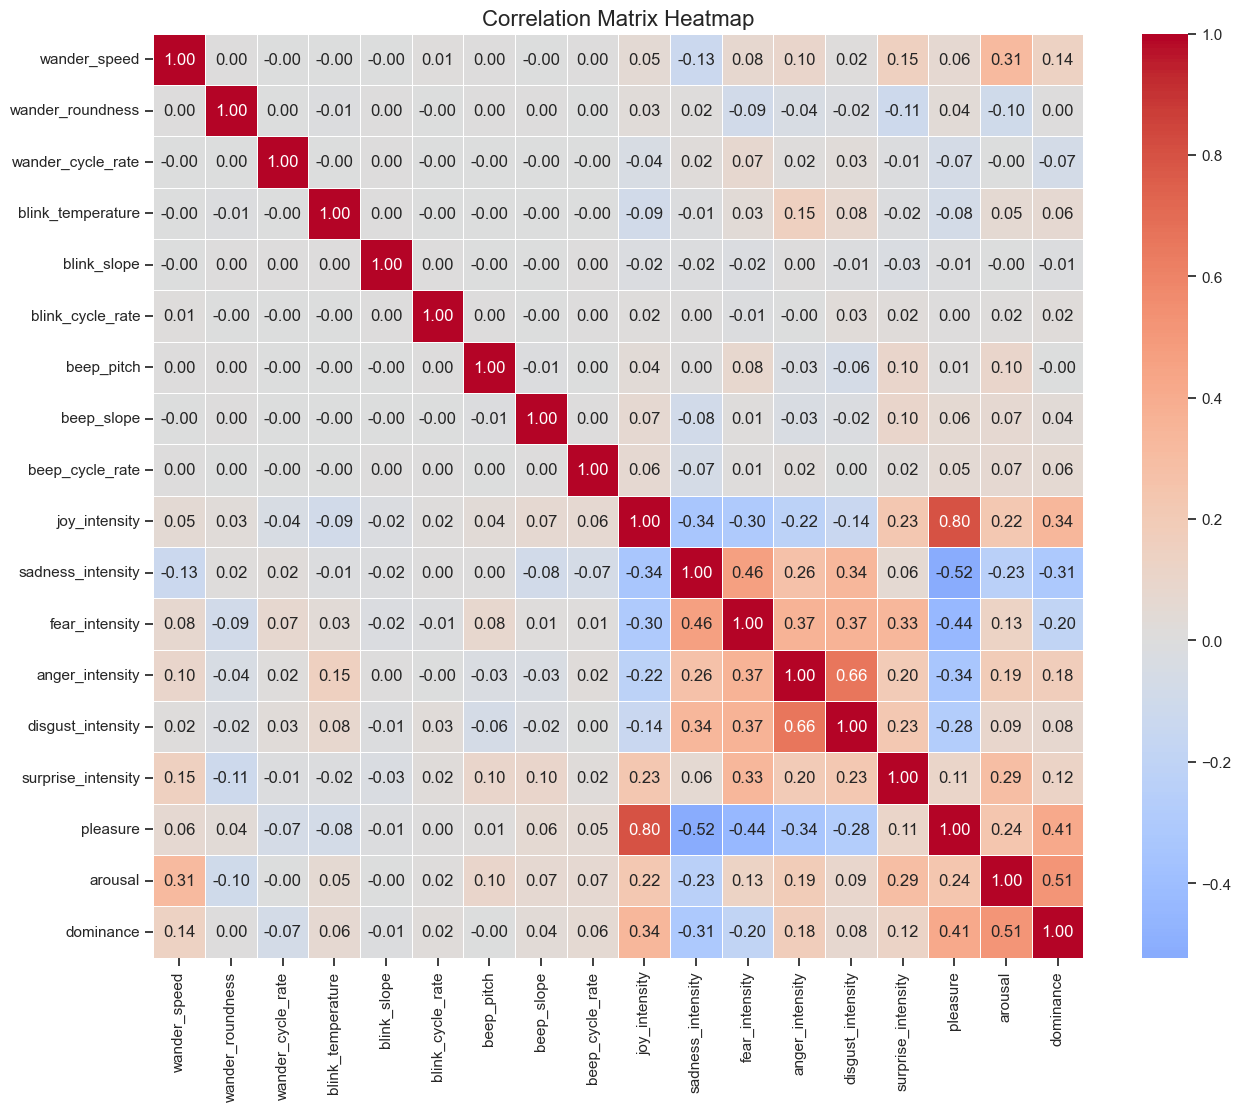

In [8]:
# List of columns to plot
columns_to_plot = data.columns[2:]

# Compute the correlation matrix
correlation_matrix = data[columns_to_plot].corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5, center=0)

# Add title to the heatmap
plt.title('Correlation Matrix Heatmap', size=16)

plt.show()

In [9]:
independent_variables = [
    'wander_speed', 'wander_roundness', 'wander_cycle_rate', 
    'blink_temperature', 'blink_slope', 'blink_cycle_rate', 
    'beep_pitch', 'beep_slope', 'beep_cycle_rate'
]

independent_continuous_variables = [
    'wander_speed', 'wander_roundness', 'wander_cycle_rate', 
    'blink_temperature', 'blink_cycle_rate', 
    'beep_pitch', 'beep_cycle_rate'
]

dependent_variables = [
    'joy_intensity', 'sadness_intensity', 'fear_intensity', 
    'anger_intensity', 'disgust_intensity', 'surprise_intensity', 
    'pleasure', 'arousal', 'dominance'
]

In [10]:
# Aggregate the dependent variables by video_id (mean, median, and mode)
dependent_aggregated_mean = data.groupby('video_id')[dependent_variables].mean().add_suffix('_mean')
dependent_aggregated_median = data.groupby('video_id')[dependent_variables].median().add_suffix('_median')
dependent_aggregated_mode = data.groupby('video_id')[dependent_variables].agg(lambda x: x.mode().iloc[0]).add_suffix('_mode')

# Merge the aggregated dependent variables with the original independent variables
aggregated_dependent_vars = pd.concat([dependent_aggregated_mean, dependent_aggregated_median, dependent_aggregated_mode], axis=1)
data = data.merge(aggregated_dependent_vars, on='video_id')
data = data.reset_index().drop_duplicates('video_id').set_index('video_id')

In [11]:
data

,start_time,end_time,wander_speed,wander_roundness,wander_cycle_rate,blink_temperature,blink_slope,blink_cycle_rate,beep_pitch,beep_slope,...,dominance_median,joy_intensity_mode,sadness_intensity_mode,fear_intensity_mode,anger_intensity_mode,disgust_intensity_mode,surprise_intensity_mode,pleasure_mode,arousal_mode,dominance_mode
video_id,,,,,,,,,,,,,,,,,,,,,
22,2024-05-08 22:59:00,2024-05-08 23:40:00,62.775115,0.688911,3.862264,0.504496,0.0,4.403772,123.816519,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0
43,2024-05-08 22:59:00,2024-05-08 23:40:00,61.110970,0.352980,4.637822,0.929641,0.0,3.738390,773.537894,0.0,...,3.5,0.0,3.0,1.0,2.0,2.0,0.0,3.0,3.0,3.0
50,2024-05-08 22:59:00,2024-05-08 23:40:00,46.017272,0.530403,3.425497,0.943638,1.0,2.511475,598.384259,1.0,...,6.5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,7.0
84,2024-05-08 22:59:00,2024-05-08 23:40:00,78.659842,0.963506,4.025686,0.931626,0.0,0.646983,689.681266,0.0,...,3.5,0.0,1.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0
125,2024-05-08 22:59:00,2024-05-08 23:40:00,74.946312,0.498299,3.467634,0.330719,-1.0,5.915387,764.680016,0.0,...,4.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2024-05-03 16:51:00,2024-05-03 17:32:00,54.808896,0.818088,3.482381,0.537533,-1.0,3.007747,973.464904,-1.0,...,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
231,2024-05-09 10:47:00,2024-05-09 11:09:00,36.870636,0.348719,1.697396,0.515061,1.0,1.043316,984.238735,0.0,...,3.5,3.0,0.0,1.0,1.0,1.0,0.0,7.0,3.0,2.0
491,2024-05-04 16:09:00,2024-05-04 16:37:00,62.628308,0.063793,5.929073,0.241175,1.0,2.963214,647.082374,1.0,...,4.5,1.0,3.0,1.0,1.0,2.0,3.0,8.0,8.0,4.0


In [12]:
# Select target variable
target_variable = 'arousal'
aggregation = 'mean'

target_aggregated_variable = target_variable + '_' + aggregation

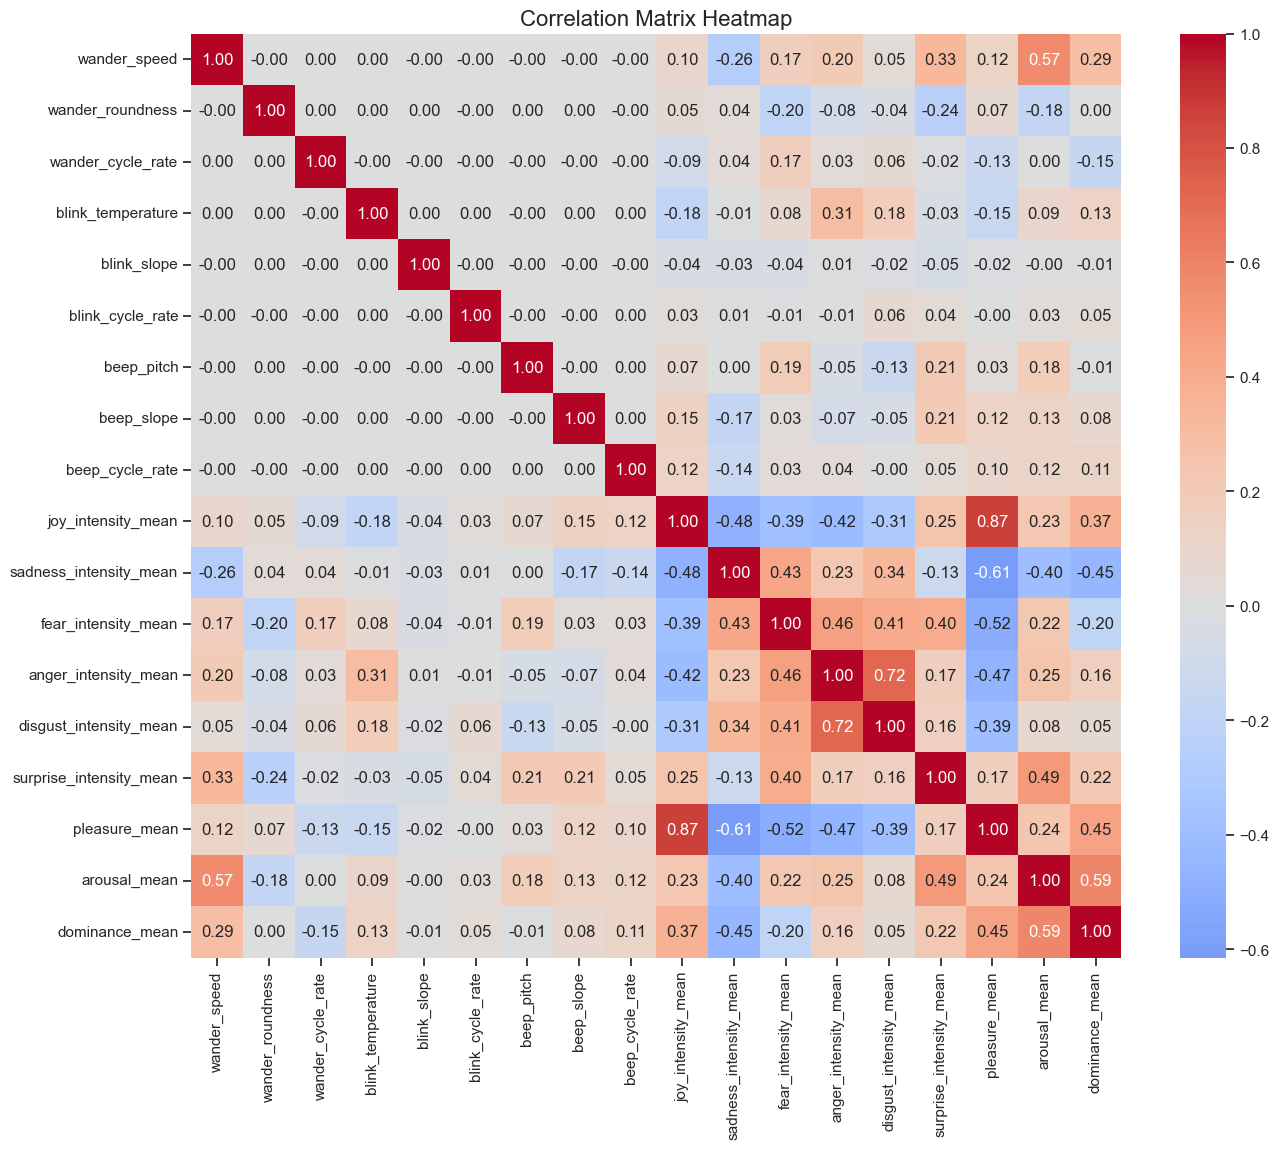

In [13]:
cols = [aggregation in column for column in data.columns]
columns_to_include = independent_variables + list(data.columns[cols])

# Compute the correlation matrix
correlation_matrix = data[columns_to_include].corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)

# Add title to the heatmap
plt.title('Correlation Matrix Heatmap', size=16)

plt.show()

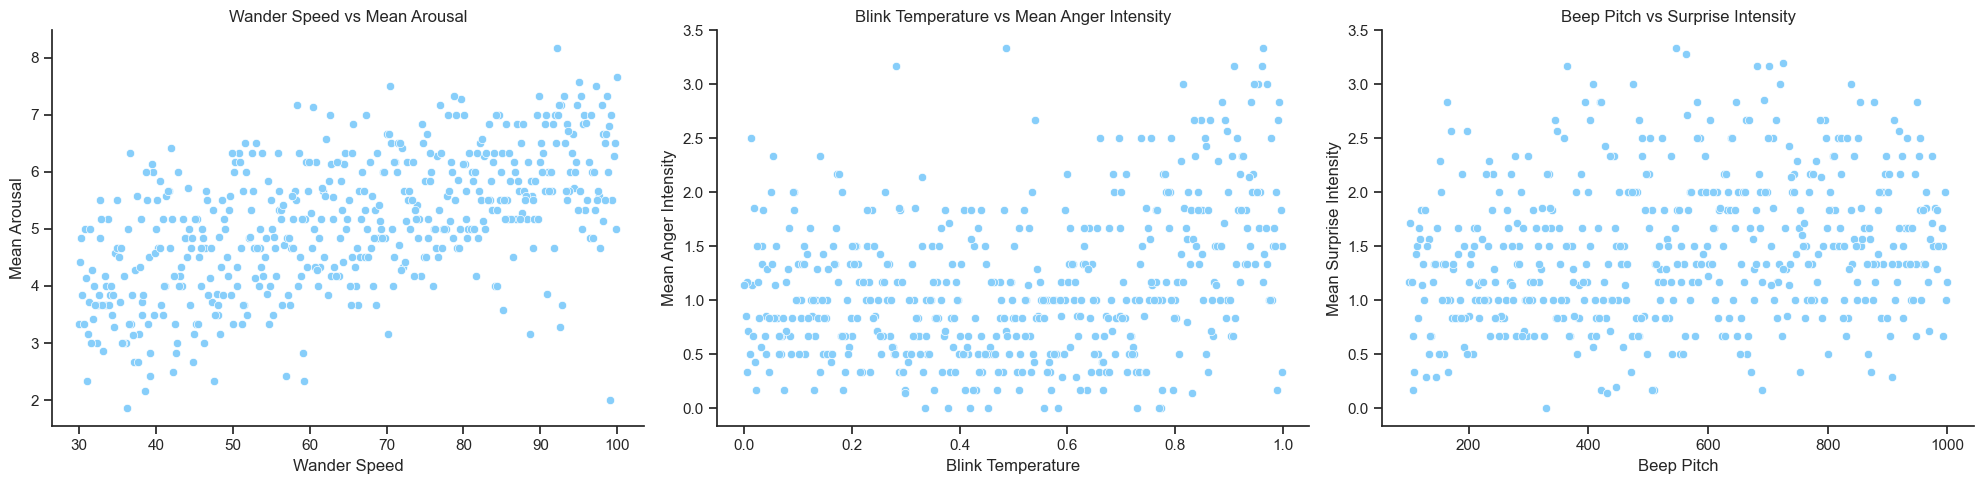

In [14]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 5))

# Scatter plot for Wander Speed vs Arousal
plt.subplot(1, 3, 1)
sns.scatterplot(data=data, x='wander_speed', y='_'.join(('arousal', aggregation)), color='lightskyblue')
plt.title('Wander Speed vs Mean Arousal')
plt.xlabel('Wander Speed')
plt.ylabel('Mean Arousal')

# Scatter plot for Blink Temperature vs Anger Intensity
plt.subplot(1, 3, 2)
sns.scatterplot(data=data, x='blink_temperature', y='_'.join(('anger_intensity', aggregation)), color='lightskyblue')
plt.title('Blink Temperature vs Mean Anger Intensity')
plt.xlabel('Blink Temperature')
plt.ylabel('Mean Anger Intensity')

# Scatter plot for Beep Pitch vs Surprise Intensity
plt.subplot(1, 3, 3)
sns.scatterplot(data=data, x='beep_pitch', y='_'.join(('surprise_intensity', aggregation)), color='lightskyblue')
plt.title('Beep Pitch vs Surprise Intensity')
plt.xlabel('Beep Pitch')
plt.ylabel('Mean Surprise Intensity')

# Display the plots
plt.tight_layout()
plt.show()

In [15]:
# Select target aggregated variable
y = data[target_aggregated_variable]

# Select independent variables
X = data[independent_variables]

In [16]:
# Standardize the independent variables before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# # Apply PCA on the independent variables
# pca = PCA(n_components=1)  # Retain 95% of the variance
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# Initialize the models
linear_reg = LinearRegression()

# Evaluate the models using cross-validation
linear_cv_scores = cross_val_score(linear_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Fit the models on the training data
linear_reg.fit(X_train, y_train)

# Make predictions on the test data
linear_preds = linear_reg.predict(X_test)

# Evaluate the models on the test data
linear_test_score = linear_reg.score(X_test, y_test)

# Output results
linear_cv_scores.mean(), linear_test_score

(-0.8444414564319619, 0.42589581751249483)

In [17]:
# Create interaction terms
for i in range(len(independent_variables)):
    for j in range(i + 1, len(independent_variables)):
        var1 = independent_variables[i]
        var2 = independent_variables[j]
        data[f'{var1}_x_{var2}'] = data[var1] * data[var2]
        if var1 in independent_continuous_variables:
            data[f'inv_{var1}_x_{var2}'] = (1 / data[var1]) * data[var2]
        if var2 in independent_continuous_variables:
            data[f'{var1}_x_inv_{var2}'] = data[var1] * (1 / data[var2])
        if var1 in independent_continuous_variables and var2 in independent_continuous_variables:
            data[f'inv_{var1}_x_inv_{var2}'] = (1 / data[var1]) * (1 / data[var2])

/var/folders/ld/hy51crss2ys6yds7_4xbfmqr0000gn/T/ipykernel_23839/580654418.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'inv_{var1}_x_inv_{var2}'] = (1 / data[var1]) * (1 / data[var2])
/var/folders/ld/hy51crss2ys6yds7_4xbfmqr0000gn/T/ipykernel_23839/580654418.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{var1}_x_{var2}'] = data[var1] * data[var2]
/var/folders/ld/hy51crss2ys6yds7_4xbfmqr0000gn/T/ipykernel_23839/580654418.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

In [18]:
# Select relevant features including the new interaction terms
mask = np.any(np.array([['wander' in column for column in data.columns],
                        ['blink' in column for column in data.columns],
                        ['beep' in column for column in data.columns]]), axis=0)

In [19]:
X_interactions = data[data.columns[mask]]

In [20]:
independent_variables_with_interactions = list(X_interactions.columns)

dependent_aggregated_variables = data.columns[[aggregation in column for column in data.columns]]

columns_to_include = independent_variables_with_interactions + list(dependent_aggregated_variables)

# Compute the correlation matrix
correlation_matrix = data[columns_to_include].corr()

In [21]:
correlation_matrix.loc[dependent_aggregated_variables, independent_variables_with_interactions]

,wander_speed,wander_roundness,wander_cycle_rate,blink_temperature,blink_slope,blink_cycle_rate,beep_pitch,beep_slope,beep_cycle_rate,wander_speed_x_wander_roundness,...,blink_cycle_rate_x_inv_beep_cycle_rate,inv_blink_cycle_rate_x_inv_beep_cycle_rate,beep_pitch_x_beep_slope,inv_beep_pitch_x_beep_slope,beep_pitch_x_beep_cycle_rate,inv_beep_pitch_x_beep_cycle_rate,beep_pitch_x_inv_beep_cycle_rate,inv_beep_pitch_x_inv_beep_cycle_rate,beep_slope_x_beep_cycle_rate,beep_slope_x_inv_beep_cycle_rate
joy_intensity_mean,0.103035,0.053202,-0.085684,-0.182601,-0.043112,0.026159,0.069885,0.148482,0.124502,0.110289,...,-0.039878,-0.078086,0.195673,0.039070,0.108797,0.034849,0.006965,-0.139354,0.083064,0.194605
sadness_intensity_mean,-0.261980,0.040689,0.040672,-0.014312,-0.029572,0.005818,0.002273,-0.173797,-0.139233,-0.104263,...,0.070389,0.000797,-0.224938,-0.069053,-0.075641,-0.099759,0.043011,0.100034,-0.103648,-0.184382
fear_intensity_mean,0.167650,-0.198934,0.166098,0.076737,-0.037789,-0.012401,0.188394,0.025409,0.030565,-0.106377,...,-0.049871,-0.027166,-0.023450,0.082165,0.163909,-0.141696,0.026467,-0.072457,0.090282,-0.052546
anger_intensity_mean,0.202316,-0.082551,0.030856,0.305422,0.010459,-0.005200,-0.053127,-0.068141,0.040195,0.029124,...,-0.040556,-0.002961,-0.082023,-0.016849,0.017817,0.049293,-0.081003,0.081786,0.005881,-0.115294
disgust_intensity_mean,0.047382,-0.038126,0.058357,0.184567,-0.015334,0.063016,-0.132238,-0.046940,-0.000581,0.008302,...,0.011194,-0.018694,-0.053625,-0.043777,-0.075244,0.067754,-0.091630,0.095177,0.039434,-0.125132
surprise_intensity_mean,0.327594,-0.237829,-0.018223,-0.034969,-0.053674,0.044551,0.212381,0.207119,0.045254,-0.059835,...,-0.022494,-0.029199,0.182060,0.172953,0.161768,-0.138677,0.097152,-0.159639,0.219742,0.134750
pleasure_mean,0.120739,0.070412,-0.131622,-0.154002,-0.016010,-0.004007,0.027590,0.120936,0.097674,0.131657,...,-0.022633,-0.015304,0.183165,0.012934,0.057372,0.045250,0.029432,-0.094139,0.041137,0.178279
arousal_mean,0.568635,-0.178927,0.000268,0.094416,-0.004250,0.028128,0.183388,0.134663,0.116767,0.099497,...,-0.023637,-0.055309,0.133432,0.084150,0.202355,-0.074035,0.045632,-0.139085,0.125443,0.118190
dominance_mean,0.290449,0.003289,-0.154890,0.125195,-0.009929,0.046251,-0.009059,0.081323,0.111952,0.146193,...,-0.011207,-0.055204,0.110799,0.024088,0.078265,0.059858,-0.039407,-0.041234,0.059810,0.103509


In [22]:
# Standardize the independent variables before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_interactions)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply PCA on the independent variables
pca = PCA(n_components=0.98)  # Retain 98% of the variance
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Initialize the models
linear_reg = LinearRegression()

# Evaluate the models using cross-validation
linear_cv_scores = cross_val_score(linear_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Fit the models on the training data
linear_reg.fit(X_train, y_train)

# Make predictions on the test data
linear_preds = linear_reg.predict(X_test)

# Evaluate the models on the test data
linear_test_score = linear_reg.score(X_test, y_test)

# Output results
linear_cv_scores.mean(), linear_test_score

(-1.2432834116467255, 0.3031400090280666)

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_interactions, y, test_size=0.3, random_state=42)

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_poly)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, R²: {r2}')

MSE: 0.7353276198165655, R²: 0.45300650073269233


In [24]:
from sklearn.linear_model import LassoCV

# Standardize the independent variables before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_interactions)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Initialize and perform LassoCV for feature selection and regularization
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[lasso.coef_ != 0]

# Fit the final model with the selected features
final_model = LinearRegression()
final_model.fit(X_train[selected_features], y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test[selected_features])

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Selected features: {selected_features}')
print(f'MSE: {mse}, R²: {r2}')

/Users/fcortevargas/Thesis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06568946491836414, tolerance: 0.0386194030176173
  model = cd_fast.enet_coordinate_descent_gram(
/Users/fcortevargas/Thesis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0513894577627525, tolerance: 0.0386194030176173
  model = cd_fast.enet_coordinate_descent_gram(
/Users/fcortevargas/Thesis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0879130219907438, tolerance: 0.0386194030176173
  model = cd_fast.enet_coordinate_descent_gram(
/Users/fcortevargas/Thesis/.ve

Selected features: Index([0, 1, 10, 17, 27, 30, 33, 39, 53, 64, 76, 82, 91, 93, 111, 114], dtype='int64')
MSE: 0.8378799545108275, R²: 0.37672015040297113


/Users/fcortevargas/Thesis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.196551443052158, tolerance: 0.039799801642169313
  model = cd_fast.enet_coordinate_descent_gram(
/Users/fcortevargas/Thesis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10484337492675877, tolerance: 0.039799801642169313
  model = cd_fast.enet_coordinate_descent_gram(
/Users/fcortevargas/Thesis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11465903484406681, tolerance: 0.039799801642169313
  model = cd_fast.enet_coordinate_descent_gram(
/Users/fcortevargas/Thes

In [25]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF for each feature
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Backward Elimination Function with VIF
def backward_elimination(X, y, significance_level=0.05, vif_threshold=10):
    while True:
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues
        max_p_value = p_values.max()
        vif = calculate_vif(X)
        max_vif = vif['VIF'].max()
        
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            X = X.drop(columns=[excluded_feature])
        elif max_vif > vif_threshold:
            excluded_feature = vif.loc[vif['VIF'] == max_vif, 'Feature'].values[0]
            X = X.drop(columns=[excluded_feature])
        else:
            break
    return X

In [26]:
X_interactions = sm.add_constant(X_interactions)

In [27]:
# Perform backward elimination
X_selected = backward_elimination(X_interactions, y)

# Fit the final model with the selected features
final_model = sm.OLS(y, X_selected).fit()

print(final_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           arousal_mean   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              1887.
Date:                Fri, 17 May 2024   Prob (F-statistic):                        0.00
Time:                        23:23:41   Log-Likelihood:                         -695.90
No. Observations:                 512   AIC:                                      1408.
Df Residuals:                     504   BIC:                                      1442.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [28]:
selected_features = X_selected.columns

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_interactions[selected_features], y, test_size=0.25, random_state=42)

In [30]:
# Fit the final model with the selected features
final_model = LinearRegression().fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Selected features: {selected_features}')
print(f'MSE: {mse}, R²: {r2}')

Selected features: Index(['wander_speed', 'beep_slope', 'inv_wander_speed_x_blink_cycle_rate',
       'wander_speed_x_inv_beep_pitch', 'wander_roundness_x_wander_cycle_rate',
       'blink_temperature_x_inv_beep_pitch',
       'inv_blink_cycle_rate_x_beep_pitch',
       'inv_blink_cycle_rate_x_beep_cycle_rate'],
      dtype='object')
MSE: 0.8129872951253794, R²: 0.36668362907276875


In [31]:
# Standardize the independent variables before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_interactions[selected_features])

# Apply PCA on the independent variables
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Select target variable
y = data[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Initialize the models
linear_reg = LinearRegression()

# Evaluate the models using cross-validation
linear_cv_scores = cross_val_score(linear_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Fit the models on the training data
linear_reg.fit(X_train, y_train)

# Make predictions on the test data
linear_preds = linear_reg.predict(X_test)

# Evaluate the models on the test data
linear_test_score = linear_reg.score(X_test, y_test)

# Output results
linear_cv_scores.mean(), linear_test_score

(-3.9962522411090524, 0.07180146768683493)

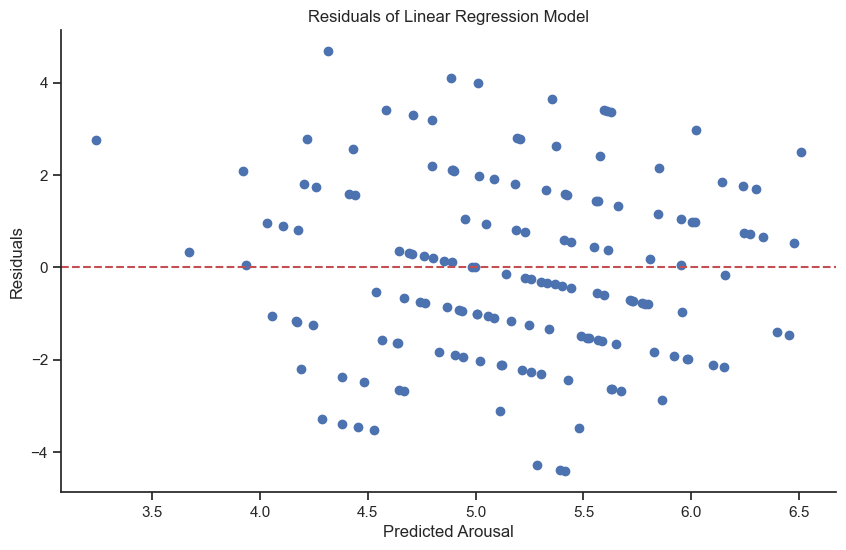

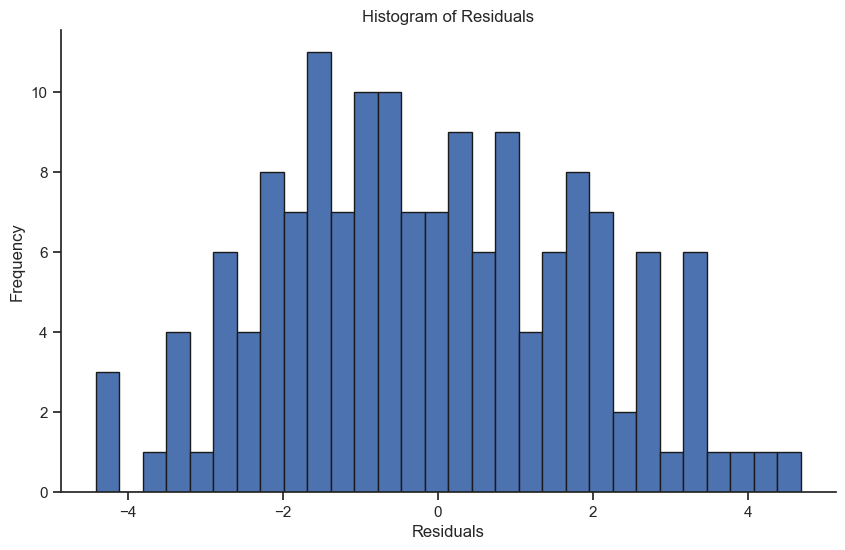

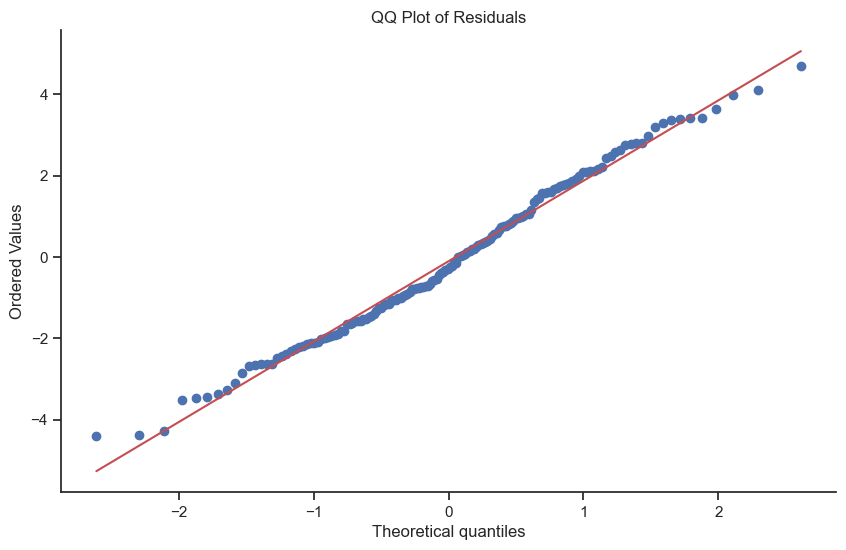

(-0.10536590426723554, 1.9579849015532422)

In [32]:
# Calculate residuals
linear_residuals = y_test - linear_preds

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(linear_preds, linear_residuals)
plt.axhline(y=0, color='r', linestyle='--')
title = target_variable.split('_')
title.insert(0, title.pop())
title = [word.title() for word in title]
plt.xlabel(f'Predicted {" ".join(title)}')
plt.ylabel('Residuals')
plt.title('Residuals of Linear Regression Model')
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(linear_residuals, bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# QQ plot for residuals
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(linear_residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()

# Calculate and print additional statistics
mean_residual = np.mean(linear_residuals)
std_residual = np.std(linear_residuals)

mean_residual, std_residual